## Code to create a 90 meter elevation data

- The code reads the elevation data from tiles (.hgt) and merges them into a single tile.

- The data is then saved to a netcdf file (elevation_SRTM90m.nc).

The 3-arc second (90 meters) resolution elevation data is downloaded from:

http://viewfinderpanoramas.org/Coverage%20map%20viewfinderpanoramas_org3.htm

The data is from Shuttle Radar Topography Mission (SRTM).

More information about the data can be found here:

http://www.viewfinderpanoramas.org/dem3.html

Make sure the following libraries are installed:

- Numpy
- Xarray
- Netcdf4

Contact information for any clarfications:

```Sridhar Mantripragada (rama.s.mantripragada@noaa.gov)```

In [1]:
import numpy as np
import xarray as xr
import re
import os

### Functions

In [2]:
def read_hgt_file(file_path, resolution=1201):
    """
    Read an HGT file and return the elevation data as a NumPy array.
    
    Args:
        file_path (str): The path to the HGT file.
        resolution (int, optional): The resolution of the HGT file. Default is 1201.
    
    Returns:
        numpy.ndarray: The elevation data as a NumPy array.
    """
    with open(file_path, 'rb') as hgt_file:
        # Read the elevation data from the HGT file and reshape it
        elevation_data = np.fromfile(hgt_file, dtype=np.dtype('>i2')).reshape((resolution, resolution)).astype(np.int16)
    
    return elevation_data


def create_xarray_from_hgt(file_path):
    """
    Create an xarray DataArray from an HGT file containing elevation data.
    
    Args:
        file_path (str): The path to the HGT file.
    
    Returns:
        xarray.DataArray: The elevation data as an xarray DataArray.
    """
    resolution = 1201
    elevation_data = read_hgt_file(file_path, resolution)
    
    # Extract latitude and longitude information from the file path
    lat_dir, lat_str, lon_dir, lon_str = re.match(r"([NS])(\d+)([EW])(\d+)", file_path[:-4].split('/')[-1]).groups()
    lat, lon = int(lat_str), int(lon_str)
    
    # Convert latitude and longitude to negative if necessary
    if lat_dir == 'S':
        lat = -lat
    if lon_dir == 'W':
        lon = -lon
    
    delta = 1 / (resolution - 1)
    lat_coords = np.linspace(lat, lat + 1, resolution)[::-1]
    lon_coords = np.linspace(lon, lon + 1, resolution)
    
    elevation_xarray = xr.DataArray(
        elevation_data,
        coords=[('lat', lat_coords), ('lon', lon_coords)],
        name='elevation'
    )
    
    # Replace invalid elevation values with NaN
    elevation_xarray = elevation_xarray.where(elevation_xarray != -32768, np.nan)
    
    return elevation_xarray

    
def combine_xarrays(xarrays):
    """
    Combine multiple xarray DataArrays into a single result.
    
    Args:
        xarrays (list): A list of xarray DataArrays.
    
    Returns:
        list: A list of combined xarray DataArrays.
    """
    xarrays_by_latitude = {}
    
    # Group xarrays by minimum latitude
    for xarray in xarrays:
        min_lat = float(xarray.lat.min())
        if min_lat not in xarrays_by_latitude:
            xarrays_by_latitude[min_lat] = []
        xarrays_by_latitude[min_lat].append(xarray)
    
    combined_rows = []
    
    # Combine xarrays row by row
    for min_lat in sorted(xarrays_by_latitude.keys(), reverse=True):
        xarrays_row = sorted(xarrays_by_latitude[min_lat], key=lambda x: float(x.lon.min()))
        combined_row = xarrays_row[0]
        
        # Concatenate xarrays within a row
        for i in range(1, len(xarrays_row)):
            combined_row = xr.concat([combined_row, xarrays_row[i][:, 1:]], dim='lon')
        
        combined_rows.append(combined_row)
    
    combined_rows[0] = combined_rows[0].astype(np.int16)
    
    # Reindex and cast subsequent rows to match the first row
    for i in range(1, len(combined_rows)):
        combined_rows[-i] = combined_rows[-i].reindex(lon=combined_rows[0].lon.values, method=None).astype(np.int16)
    
    return combined_rows

### Main code

*The below cell takes longer time to execute. Please be patient.*

In [3]:
directory = 'data/'

file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.hgt')]

xarrays = [create_xarray_from_hgt(file_path) for file_path in file_paths]

combined_rows = combine_xarrays(xarrays)

# Concatenate the xarrays along the 'lat' dimension
concatenated_xarray = xr.concat(combined_rows, dim='lat')

C:\Users\rama.s.mantripragad\Anaconda3\envs\vol13\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\rama.s.mantripragad\Anaconda3\envs\vol13\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\rama.s.mantripragad\Anaconda3\envs\vol13\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\rama.s.mantripragad\Anaconda3\envs\vol13\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\rama.s.mantripragad\Anaconda3\envs\vol13\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\rama.s.mantripragad\Anaconda3\envs\v

In [4]:
concatenated_xarray

<xarray.DataArray 'elevation' (lat: 32427, lon: 90001)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * lat      (lat) float64 51.0 51.0 51.0 51.0 51.0 ... 24.0 24.0 24.0 24.0 24.0
  * lon      (lon) float64 -130.0 -130.0 -130.0 -130.0 ... -55.0 -55.0 -55.0

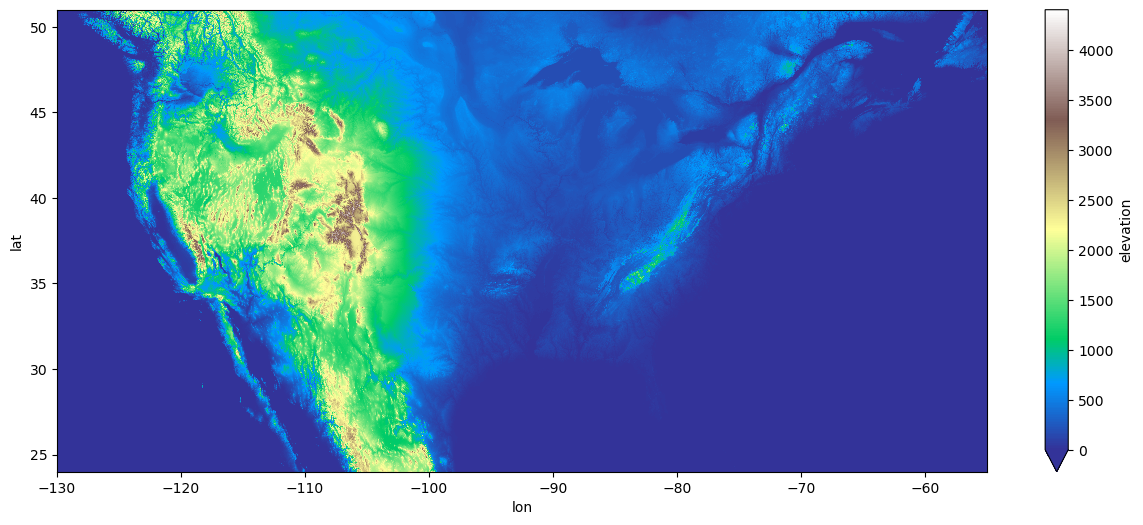

In [5]:
vmax = concatenated_xarray.max()
concatenated_xarray.plot.imshow(vmin=0, vmax=vmax,figsize=(15,6),cmap='terrain')

### Save elevation to Netcdf file

In [6]:
encoding = {'elevation': {'zlib': True, 'complevel': 4}}  # Adjust 'complevel' (1-9) to control the compression level
concatenated_xarray.to_netcdf('elevation_SRTM90m.nc', engine='netcdf4', encoding=encoding)